In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.stats import multivariate_normal
from numpy.core.function_base import linspace
from numpy.lib import dstack
from scipy.linalg import eigh
import time
from IPython.display import clear_output



In [41]:
class GMM:
    
    def __init__(self,k,e,file_path=None,X=None):
        if file_path is None:
            self.k = k
            self.e = e
            self.N = X.shape[0]
            self.num_features = X.shape[1]
            mean = np.mean(X, axis=0)
            std_dev = np.std(X, axis=0)
            self.X = (X - mean) / std_dev
            self.data = self.X
            # initializing the mean and cov matrix and weights
            self.mean = np.zeros((self.k,self.num_features))
            self.cov = np.zeros((self.k,self.num_features,self.num_features))
            self.weights = np.ones((self.k,1))
        else:
            self.k = k
            self.data = pd.read_csv(file_path)
            self.data = self.data.drop(self.data.columns[0], axis=1)
            
            for column_number in range(0,self.data.shape[1]):

                column_mean = self.data.iloc[:, column_number].mean()
                column_std_dev = self.data.iloc[:, column_number].std()

                # Standardize the selected column to have mean 0 and standard deviation 1
                self.data.iloc[:, column_number] = (self.data.iloc[:, column_number] - column_mean) / column_std_dev

            # print("data standardized!")
            
            # number of samples and num features
            self.N = self.data.shape[0]
            self.num_features = self.data.shape[1]
            
            # initializing the mean and cov matrix and weights
            self.mean = np.zeros((self.k,self.num_features))
            self.cov = np.zeros((self.k,self.num_features,self.num_features))
            self.weights = np.ones((self.k,1))
            
            # converting the dataframe to np matrix (for manipulation)
            self.X = (self.data.to_numpy())
            # print(self.X.shape)
            
            # initializing convergence parameter e
            self.e = e
        
    def printParameters(self):
        print('Parameters of the GMM object')
        print('_________________________________')
        print('> number of samples      : ',self.N)
        print('> number of features     : ',self.num_features)
        print('> number of clusters     : ',self.k)
        print('> convergence tolerance  : ',self.e)
        print('_________________________________\n')
        
        
        
    # initializing the means, cov matrices and weights of the k gaussians
    def initialize_parameters(self):
        # initializing mean, cov, weights, responsibilities and log-likelihood randomly
        for k in range(self.k):
            self.mean[k] = np.random.normal(size=(1,self.num_features))
            self.cov[k] = np.eye(self.num_features)
        self.weights = self.weights/self.k
        self.r = np.zeros((self.k,self.N))
        self.loglike = [0]
    
    
    # applying the EM algorithm for GMM
    # routine to fit data
    def fit(self):
        
        for i in range(1000):
            
            # E step
            for k in range(self.k):
                self.r[k] = self.weights[k]*multivariate_normal.pdf(self.X,mean=self.mean[k,:],cov=self.cov[k,:,:])

            self.r = self.r/np.sum(self.r,axis=0)

            # M step
            # finding out sum of responsibilities for all gms
            Nk = np.sum(self.r, axis=1)
            Nk = Nk.reshape(-1, 1)

            # finding out mean matrix based on the responsibilities
            self.mean = np.dot(self.r, self.X)
            self.mean = self.mean / Nk
            
            # calculating cov matrices (7,7) for each k
            for k in range(self.k):
                sum = np.zeros((self.X.shape[1],self.X.shape[1]))
                for n in range(self.N):
                    vec = self.X[n]-self.mean[k]
                    sum = sum + self.r[k,n]*(np.outer(vec,vec))
                sum = sum / Nk[k]
                # Regularization with 1e-6 (to make cov pos-semidefinite)
                self.cov[k] = sum + np.eye(self.num_features,self.num_features)*1e-6
            
            self.weights = np.sum(self.r,axis=1)/self.N
                
            ll = self.loglikelihood()
            self.loglike.append(ll)
            # print(f"iteration : {i+1}\t\tlog-likelihood : {ll}")
            # print('iteration : ',i+1,'\t\tlikelihood = ',ll)
            # print('time taken = ',end_time-start_time)
            if np.abs(self.loglike[i]-self.loglike[i+1]) < self.e:
                print('\nConvergence achieved at iteration : ',i+1)
                break
                
                
    # def calculate_likelihoods(self):
    #     # gauss = 0
    #     # for k in range(self.k):
    #     #     if np.isinf(self.X).sum()>0:
    #     #         print('INF found')
    #     #     ll = self.weights[k]*multivariate_normal.pdf(self.X,self.mean[k,:],self.cov[k,:,:])
    #     #     gauss = gauss + ll
    #     # ret = -np.sum(np.log(gauss))
    #     # return ret
        
    #     loglikelihood = 0
    #     for n in range(self.N):
    #         sum = 0
    #         for k in range(self.k):
    #             sum = sum + self.weights[k]*multivariate_normal.pdf(self.X[n],self.mean[k],self.cov[k])
    #         loglikelihood = loglikelihood + np.log(sum)
    #     return -loglikelihood

    # routine to calculate the likelihoods
    
    def loglikelihood(self):
        ll = 0
        for k in range(self.k):
            ll += self.weights[k] * multivariate_normal.pdf(self.X,self.mean[k,:],self.cov[k,:,:])
        return -np.sum(np.log(ll))

    # verify formula for BIC
    def getBIC(self):
        num_parameters = self.k * (( self.data.shape[1] * (self.data.shape[1] + 1) ) / 2) + (self.k - 1) + self.k * self.data.shape[1]
        self.bic = -2 * self.loglike[len(self.loglike)-1] + np.log(self.N) * num_parameters
        return self.bic

    def getAIC(self):
        num_parameters = self.k * (( self.data.shape[1] * (self.data.shape[1] + 1) ) / 2) + (self.k - 1) + self.k * self.data.shape[1]
        # self.aic = -2* self.loglike[len(self.loglike)-1] + 2*self.k
        self.aic = -2 * self.loglike[len(self.loglike)-1] + 2 * num_parameters
        return self.aic
    
    # a routine to obtain the parameters
    def get_parameters(self):
        return self.mean,self.cov,self.weights
    
    #  routine to obtain the membership values of data samples
    def get_membership_values(self):
        return self.r.T

    # get log-likelihood vector 
    def getLogLikelihood(self):
        return self.loglike
    
    def plotLogLikelihood(self):
        plt.plot(self.loglike[1:])
        plt.xlabel('iteration')
        plt.ylabel('Log-Likelihood')
        plt.title('Convergence of Log-Likelihood')
        plt.grid(True)
        plt.show()
        print('last ll = ',self.loglike[len(self.loglike)-1])

            
                

Parameters of the GMM object
_________________________________
> number of samples      :  2000
> number of features     :  7
> number of clusters     :  10
> convergence tolerance  :  1e-06
_________________________________


Convergence achieved at iteration :  28


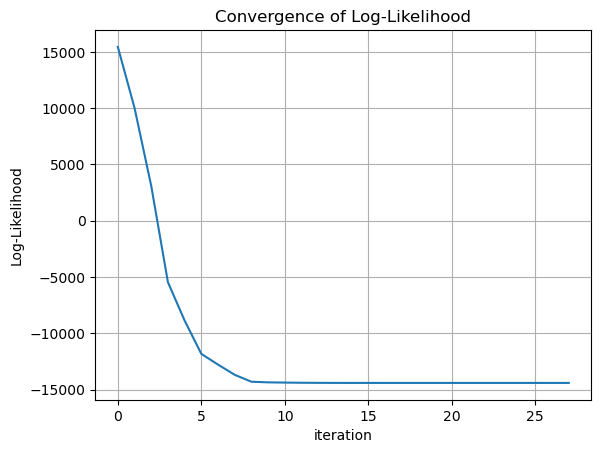

last ll =  -14396.501771864358


In [42]:

file_path = './SMAI-Dataset-customer-dataset/data.csv'
gmm = GMM(10,1e-6,file_path)
gmm.printParameters()
gmm.initialize_parameters()
gmm.fit()
gmm.plotLogLikelihood()

Observations : 
- We can clearly see that the log-likelihood is decreasing and converging to a constant value 
- When the change in log likelihood becomes very small (less than e), then, we stop the EM iterations and return the results

In [43]:
# loading wine-dataset
from sklearn.datasets import load_wine

wine_data = load_wine()

X = wine_data.data  # Features (attribute values)
Y = wine_data.target  # Target labels (class labels)
feature_names = wine_data.feature_names  # Feature names
description = wine_data.DESCR  # Dataset description

print("Wine dataset :\n_________________________________________")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(set(Y))}")
print(f"Feature names: {', '.join(feature_names)}")
# print(description)

print(X)



Wine dataset :
_________________________________________
Number of samples: 178
Number of features: 13
Number of classes: 3
Feature names: alcohol, malic_acid, ash, alcalinity_of_ash, magnesium, total_phenols, flavanoids, nonflavanoid_phenols, proanthocyanins, color_intensity, hue, od280/od315_of_diluted_wines, proline
[[1.423e+01 1.710e+00 2.430e+00 ... 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 ... 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 ... 1.030e+00 3.170e+00 1.185e+03]
 ...
 [1.327e+01 4.280e+00 2.260e+00 ... 5.900e-01 1.560e+00 8.350e+02]
 [1.317e+01 2.590e+00 2.370e+00 ... 6.000e-01 1.620e+00 8.400e+02]
 [1.413e+01 4.100e+00 2.740e+00 ... 6.100e-01 1.600e+00 5.600e+02]]


Parameters of the GMM object
_________________________________
> number of samples      :  178
> number of features     :  13
> number of clusters     :  3
> convergence tolerance  :  1e-05
_________________________________


Convergence achieved at iteration :  18


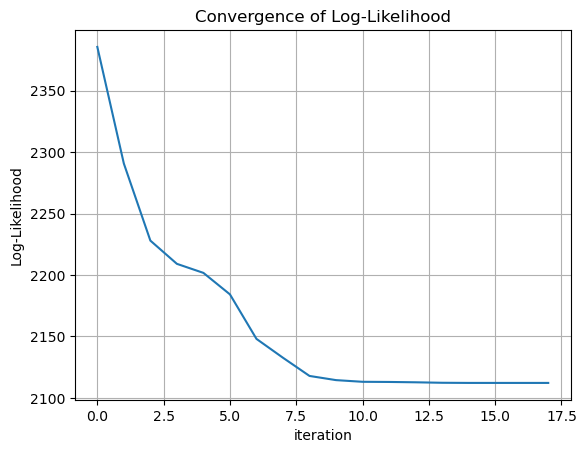

last ll =  2112.186695175091


In [50]:
# performing clustering on wine dataset using GMM
num_clusters = 3
e = 1e-5

gmm_wine = GMM(k=num_clusters,e=e,X=X)
gmm_wine.printParameters()
gmm_wine.initialize_parameters()
gmm_wine.fit()
gmm_wine.plotLogLikelihood()

In [45]:
# performing clustering on wine-dataset using K-means
from sklearn.cluster import KMeans

K = 3
kmeans = KMeans(n_clusters=K, random_state=0)

kmeans.fit(X)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

10296.895242959828
optimal K according to aic score :  0
optimal K according to bic score :  0
Something Wrong here -> check


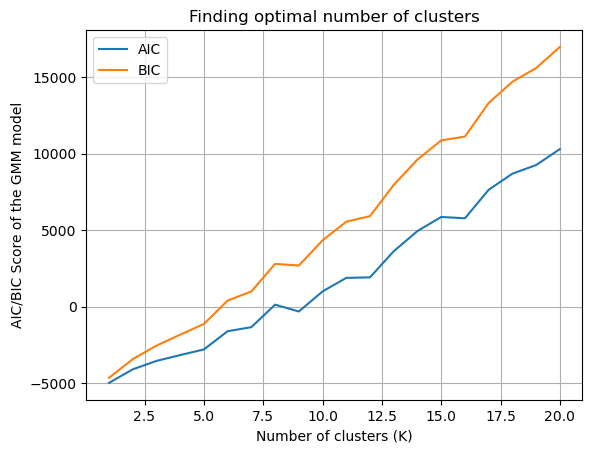

In [47]:
# calculating optimal number of clusters using AIC and BIC
min_clusters = 1
max_clusters = 20

aic_array = []
bic_array = []

for k in range(min_clusters,max_clusters+1):
    gmm_test = GMM(k=k,e=1e-6,X=X)
    # gmm_test.printParameters()
    gmm_test.initialize_parameters()
    gmm_test.fit()
    clear_output()
    # gmm_test.plotLogLikelihood()
    aic = gmm_test.getAIC()
    bic = gmm_test.getBIC()
    print(aic)
    aic_array.append(aic)
    bic_array.append(bic)

# print(aic_array)


aic_optimal = aic_array.index(min(aic_array))
bic_optimal = bic_array.index(min(bic_array))

print('optimal K according to aic score : ',aic_optimal)
print('optimal K according to bic score : ',bic_optimal)

print('Something Wrong here -> check')    

x_axis = [i for i in range(min_clusters,max_clusters+1)]
plt.plot(x_axis,aic_array,label='AIC')
plt.plot(x_axis,bic_array,label='BIC')
plt.legend()
plt.legend()
plt.grid(True)
plt.xlabel('Number of clusters (K)')
plt.ylabel('AIC/BIC Score of the GMM model')
plt.title('Finding optimal number of clusters')
plt.show()

    


In [11]:
# reducing the number of dimensions to 2 using PCA
# standardizes data into 0 mean and 1 variance
def standardize_data(X):
    for f in range(X.shape[1]):
        X[:,f] = (X[:,f]-np.mean(X[:,f]))/np.std(X[:,f])
    return X

# returns the set of eigenvalues and eigenvectors of A in sorted fashion
def getEigen(A,iterations=10):
    Ak = np.copy(A)
    n = A.shape[0]
    QQ = np.eye(n)
    for k in range(iterations):
        Q, R = np.linalg.qr(Ak)
        Ak = R @ Q
        QQ = QQ @ Q
            
    values = np.diag(Ak)
    vectors = QQ
    
    # sorting the eigenvectors and eigenvalues based on dec eigenvalues
    sorted_ind = np.argsort(-values) # -ve sign for decreasing order of eigenvalues
    sorted_values = values[sorted_ind]
    sorted_vectors = vectors[sorted_ind]

    return sorted_values, sorted_vectors



Uncomment this section if you want to do PCA on the customer dataset

In [12]:
file_path = './SMAI-Dataset-customer-dataset/data.csv'

data = pd.read_csv(file_path)
data = data.drop(data.columns[0], axis=1)

for column_number in range(0,data.shape[1]):
    column_mean = data.iloc[:, column_number].mean()
    column_std_dev = data.iloc[:, column_number].std()

    # Standardize the selected column to have mean 0 and standard deviation 1
    data.iloc[:, column_number] = (data.iloc[:, column_number] - column_mean) / column_std_dev

# print("data standardized!")

# number of samples and num features
N = data.shape[0]
num_features = data.shape[1]

# converting the dataframe to np matrix (for manipulation)
X = (data.to_numpy())

# calculating the covariance matrix of X
cov = np.cov(X,rowvar=False)

# finding sorted eigenvalues and corresponding eigenvectors of S=XXt
e_vals, e_vects = getEigen(cov)



Uncomment this section if you want to do PCA on the wine dataset

In [13]:
# wine_data = load_wine()

# X = wine_data.data  # Features (attribute values)
# Y = wine_data.target  # Target labels (class labels)

# # calculating the covariance matrix of X
# cov = np.cov(X,rowvar=False)

# # finding sorted eigenvalues and corresponding eigenvectors of S=XXt
# e_vals, e_vects = getEigen(cov)


In [14]:

k = 2
eigen_values = e_vals[:k]
eigen_vectors = e_vects[:k]

X_new = np.dot(X, eigen_vectors.T)



Parameters of the GMM object
_________________________________
> number of samples      :  2000
> number of features     :  2
> number of clusters     :  2
> convergence tolerance  :  1e-06
_________________________________


Convergence achieved at iteration :  181


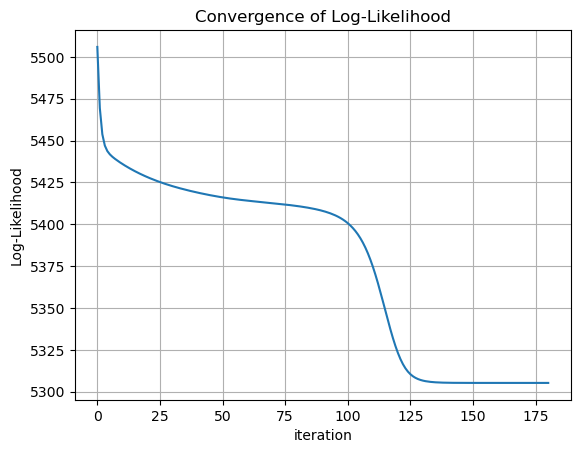

last ll =  5305.237775152387


In [15]:
gmm_reduced = GMM(k=2,e=1e-6,X=X_new)
gmm_reduced.printParameters()
gmm_reduced.initialize_parameters()
gmm_reduced.fit()
gmm_reduced.plotLogLikelihood()


In [16]:
def visualize_gaussians(X, means, cov_matrices):

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    colors = ['r', 'g', 'c', 'm', 'y']
    colors = colors[0:len(means)]

    for i, (mean, cov_matrix) in enumerate(zip(means, cov_matrices)):
        rv = multivariate_normal(mean=mean, cov=cov_matrix)
        zz = np.reshape(rv.pdf(np.c_[xx.ravel(), yy.ravel()]), xx.shape)

        plt.contour(xx, yy, zz, levels=[0.05], colors='b', alpha=0.7, linewidths=2)

    cluster_labels = np.argmax([multivariate_normal(mean=mean, cov=cov_matrix).pdf(X) for mean, cov_matrix in zip(means, cov_matrices)], axis=0)

    for i, color in enumerate(colors):
        plt.scatter(X[cluster_labels == i][:, 0], X[cluster_labels == i][:, 1], c=color, marker='.', s=20, label=f'Cluster {i + 1}')

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.grid(True)
    plt.title("Visualizing Clusters in the dataset")
    plt.show()


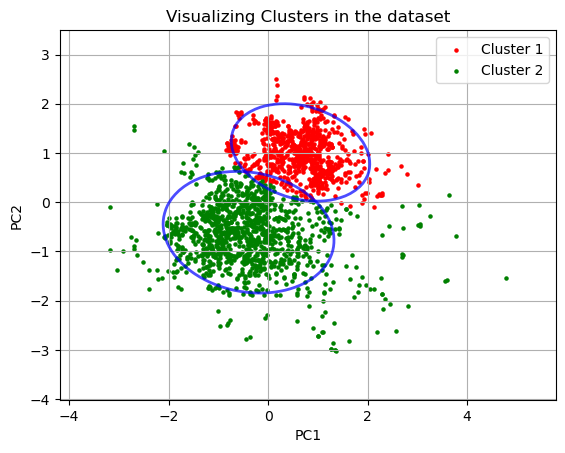

In [17]:
mean,cov,weights = gmm_reduced.get_parameters()
X = gmm_reduced.X
visualize_gaussians(X,mean,cov)

Observations : 
- The scatter plots are properly grouped.

- Since we have taken the first 2 PCs as axes and ploted scatter plot, the variance is quite high
- Due to this high variance in both axes, the clustering has quite a number of outliers.
- Although this is the highest level of variance the model can have in 2 dimension, the clustering is still quite accurate
- If we were to increase the number of PCs and try clustering, the clustering would become better only, since the variances in the newly intrduced axes will be even lower

In [ ]:
def calculate_probability_density(x, mu, sigma):
    # Calculate the probability density of x under the Gaussian distribution
    n = x.shape[0]  # Dimensionality of the data
    det_sigma = np.linalg.det(sigma)
    inv_sigma = np.linalg.inv(sigma)
    exponent = -0.5 * np.dot(np.dot((x - mu).T, inv_sigma), (x - mu))
    probability_density = (1 / (np.sqrt((2 * np.pi) ** n * det_sigma))) * np.exp(exponent)
    return probability_density


In [76]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# finding cluster assignments
means = gmm_reduced.mean
cov_matrices = gmm_reduced.cov
weights = gmm_reduced.weights
X = gmm_reduced.X

# NOTE : Since the means and cov and weights are already calculated using our implementation of GMM, the below function of GMM stops at 1st iteration

gmm = GaussianMixture(n_components=2)  # Initialize the GMM model
gmm.means_ = means  # Set the mean vectors
gmm.covariances_ = cov_matrices  # Set the covariance matrices
gmm.weights_ = weights  # Set the weights

# Fit the GMM to the data and obtain cluster assignments
cluster_assignments = gmm.fit_predict(X)

# Calculate the silhouette score
silhouette_avg = silhouette_score(X, cluster_assignments)
print("Silhouette Score for Reduced GMM:", silhouette_avg)


Silhouette Score for Reduced GMM: 0.4525337811849319
